In [1]:
#depth change along crossection
from netCDF4 import Dataset
import numpy as  np
import matplotlib.pyplot as plt

import math
import glob
import os.path
import sys
sys.path.insert(0, '/home/g/g260204/tools/python_skripts/SchismUtils/')
from schism_utils import read_data, sort_files, tol_colors
import h5py
import os.path
import pandas as pd

from matplotlib import rcParams
rcParams['figure.dpi'] = 300
#plt.rc('axes', prop_cycle=plt.cycler('color', list(tol_colors.tol_cset('muted'))))

In [2]:
#input
outname = 'srm024'
basesims = ['srm024_']
labels = ['ref']
simpat = '/work/gg0877/g260204/sim_data/SR5yr/'
#date_start = [2010,6,1]
plot_path = '/work/gg0877/g260204/sim_data/SR5yr/plots/plots/' + outname + '/'
transfiles = '/work/gg0877/g260204/data/transects/'

if not os.path.exists(plot_path):
    os.makedirs(plot_path)


In [3]:
#read topo data
import geopandas as gpd
transfilestopo = '/work/gg0877/g260204/data/transects/topo/'

cct = gpd.read_file(transfilestopo + 'cross_channels_fine_topo_2014.shp')
xcct,ycct = cct.geometry[0].coords.xy
cct_xy = pd.DataFrame(list(zip(xcct,ycct)),columns=['LAT','LON'])

cft = gpd.read_file(transfilestopo + 'cross_flats_fine_topo_2014.shp')
xcft,ycft = cft.geometry[0].coords.xy
cft_xy = pd.DataFrame(list(zip(xcft,ycft)),columns=['LAT','LON'])
#cft_z = np.array([t[2] for t in cft.geometry[0].coords[:]])  

cf2t = gpd.read_file(transfilestopo + 'cross_flats2_fine_topo_2014.shp')
xcf2t,ycf2t = cf2t.geometry[0].coords.xy
cf2t_xy = pd.DataFrame(list(zip(xcf2t,ycf2t)),columns=['LAT','LON'])    

bnd = gpd.read_file(transfilestopo + 'boundary_fine_topo_2014.shp')
xbnd,ybnd = bnd.geometry[0].coords.xy
bnd_xy = pd.DataFrame(list(zip(xbnd,ybnd)),columns=['LAT','LON'])   




def haversine(point1, point2):
    import math

    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = point1
    lon2, lat2 = point2

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers


    return km

#distance along transects
tmp = []
for i in range(0,np.size(xcct)-1):
    dist = haversine([cct_xy['LAT'][i],cct_xy['LON'][i]], [cct_xy['LAT'][i+1],cct_xy['LON'][i+1]])
    tmp.append(dist)
cct_dist = np.append(0, np.cumsum(tmp))

tmp = []
for i in range(0,np.size(xcft)-1):
    dist = haversine([cft_xy['LAT'][i],cft_xy['LON'][i]], [cft_xy['LAT'][i+1],cft_xy['LON'][i+1]])
    tmp.append(dist)
cft_dist = np.append(0, np.cumsum(tmp))

tmp = []
for i in range(0,np.size(xcf2t)-1):
    dist = haversine([cf2t_xy['LAT'][i],cf2t_xy['LON'][i]], [cf2t_xy['LAT'][i+1],cf2t_xy['LON'][i+1]])
    tmp.append(dist)
cf2t_dist = np.append(0, np.cumsum(tmp))

tmp = []
for i in range(0,np.size(xbnd)-1):
    dist = haversine([bnd_xy['LAT'][i],bnd_xy['LON'][i]], [bnd_xy['LAT'][i+1],bnd_xy['LON'][i+1]])
    tmp.append(dist)
bnd_dist = np.append(0, np.cumsum(tmp))

#read data
ncf = simpat + basesims[0] + '2010/outputs/schout_365.nc'
ncdata = Dataset(ncf, mode='r')
keys = ncdata.variables.keys()
#time independent
x       = ncdata.variables['SCHISM_hgrid_node_x'][:]
y       = ncdata.variables['SCHISM_hgrid_node_y'][:]
tri     = ncdata.variables['SCHISM_hgrid_face_nodes'][:,:3]-1
simxy = np.array([x,y]).reshape(48883,2)

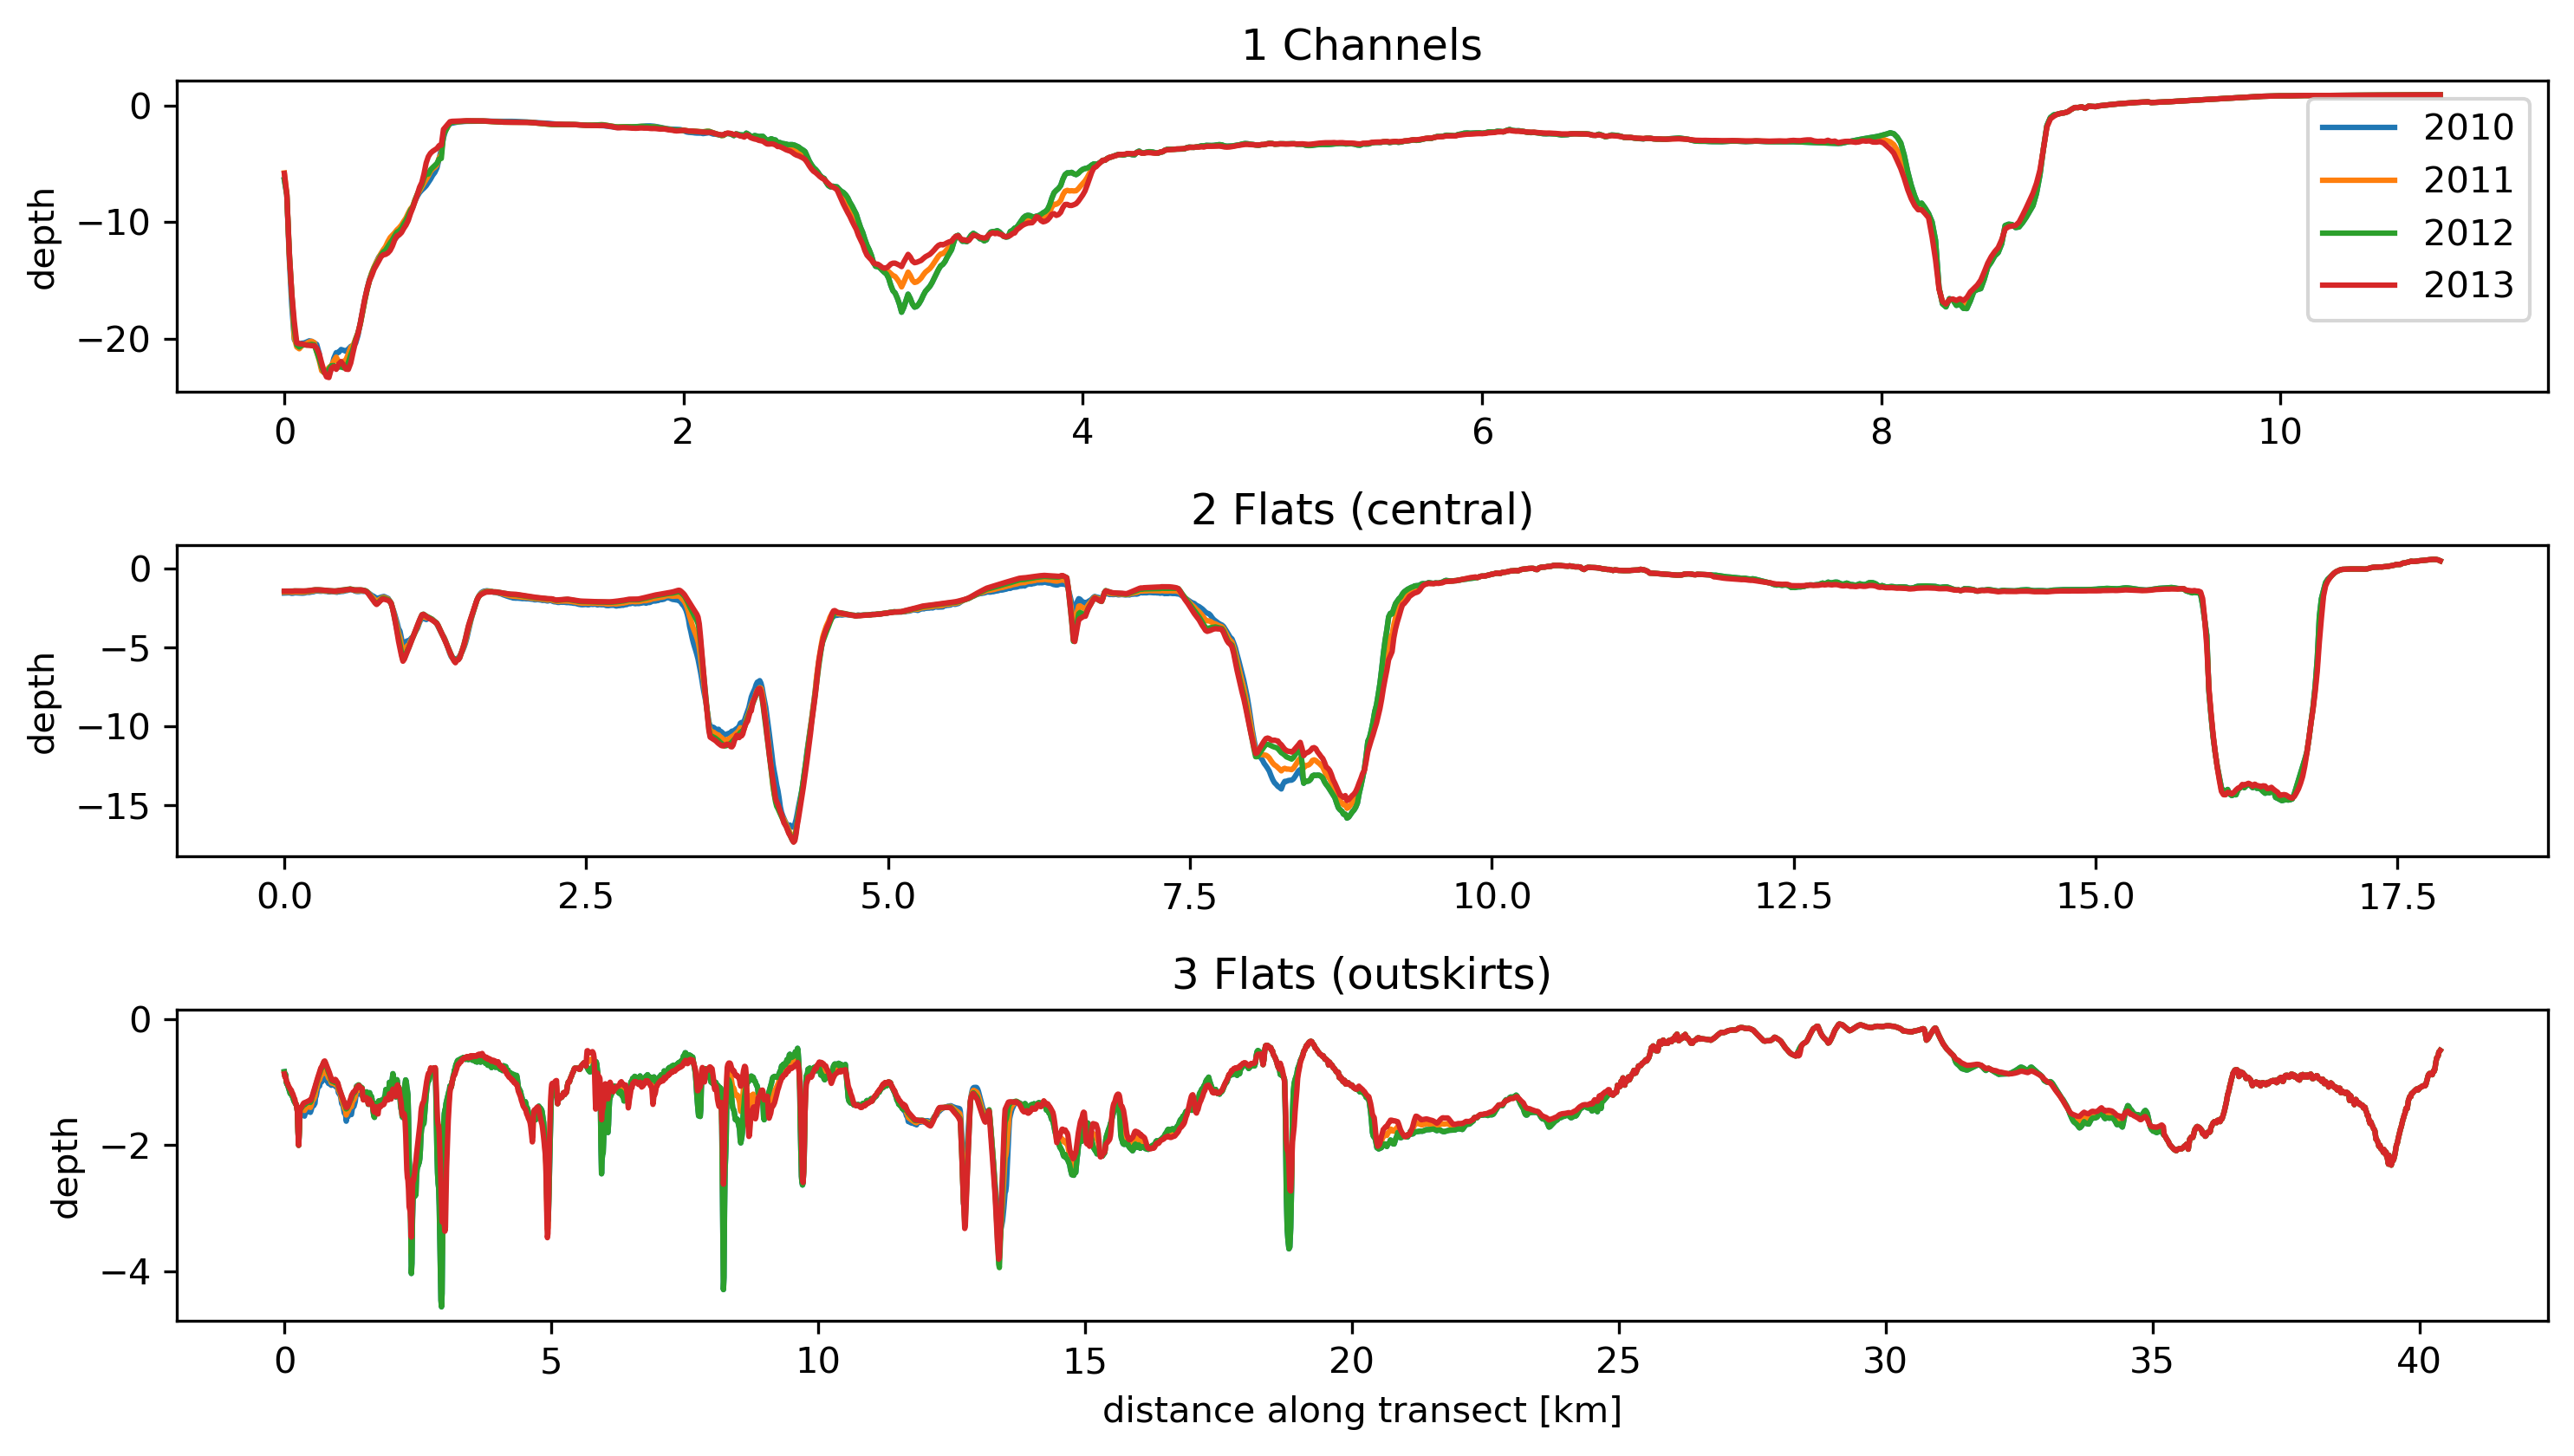

In [4]:
#figure - observations depth
#read transect data

fig, axs = plt.subplots(3,1, figsize=(10, 6))
for i in range(2010,2014):
    cct = gpd.read_file(transfilestopo + 'cross_channels_fine_topo_'+str(i)+'.shp')
    cct_z = np.array([t[2] for t in cct.geometry[0].coords[:]])
    cft = gpd.read_file(transfilestopo + 'cross_flats_fine_topo_'+str(i)+'.shp')
    cft_z = np.array([t[2] for t in cft.geometry[0].coords[:]])
    cf2t = gpd.read_file(transfilestopo + 'cross_flats2_fine_topo_'+str(i)+'.shp')
    cf2t_z = np.array([t[2] for t in cf2t.geometry[0].coords[:]])
    
    axs[0].plot(cct_dist,cct_z,label=str(i))
    axs[0].set_title('1 Channels')
    axs[0].set_ylabel('depth')
    axs[0].legend()
    axs[1].plot(cft_dist,cft_z,label=str(i))
    axs[1].set_title('2 Flats (central)')
    axs[1].set_ylabel('depth')
    axs[2].plot(cf2t_dist,cf2t_z,label=str(i))
    axs[2].set_title('3 Flats (outskirts)')
    axs[2].set_xlabel('distance along transect [km]')
    axs[2].set_ylabel('depth')
    plt.subplots_adjust(top=0.9)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig(plot_path + '5yrs_obs_depth_across_flats2_fine.png')

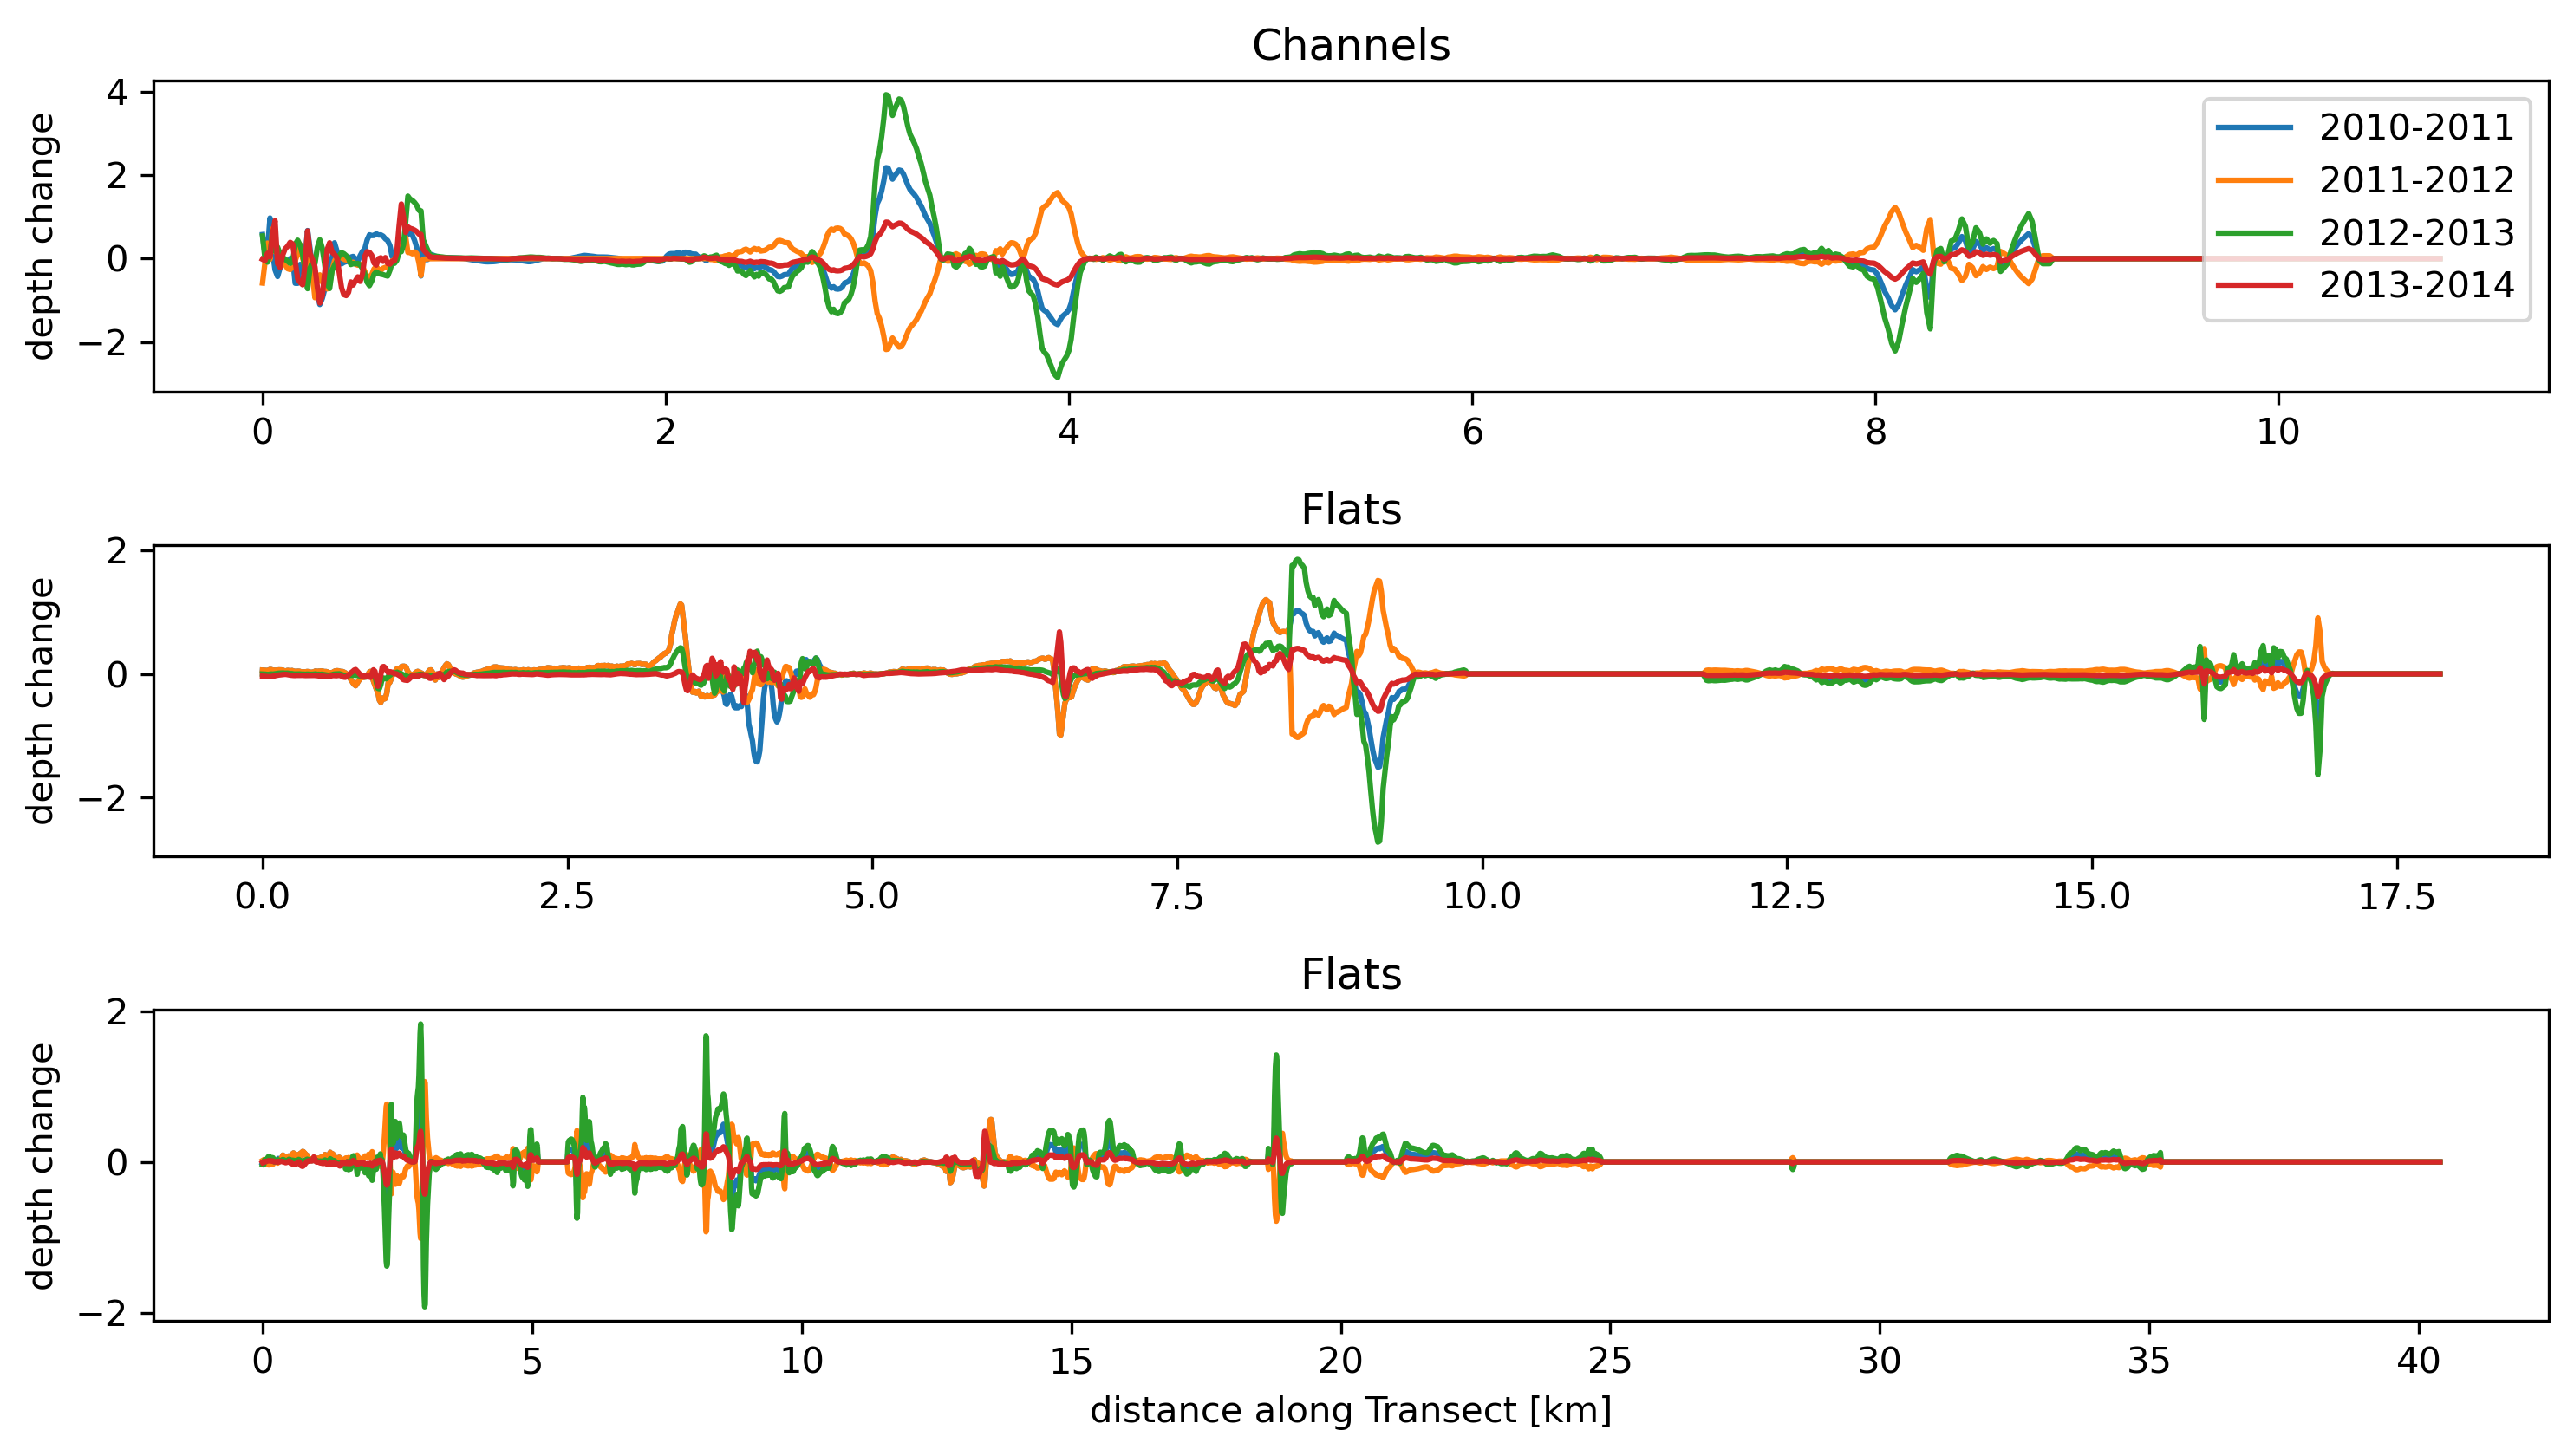

In [5]:
#depth changes obs:
#load measurement data
sumzcct = np.zeros(np.size(xcct))
sumzcft = np.zeros(np.size(xcft))
sumzcf2t = np.zeros(np.size(xcf2t))
sumzbnd = np.zeros(np.size(xbnd))

fig, axs = plt.subplots(3,1, figsize=(10, 6))
nobs = 0
for i in range(2010,2014):
    f1 = gpd.read_file(transfilestopo + 'cross_channels_fine_topo_'+str(i)+'.shp')
    z1= np.array([t[2] for t in f1.geometry[0].coords[:]])
    f2 = gpd.read_file(transfilestopo + 'cross_channels_fine_topo_'+str(i+1)+'.shp')
    z2 = np.array([t[2] for t in f2.geometry[0].coords[:]])
    cct_diff = (z2-z1)
    
    f1 = gpd.read_file(transfilestopo + 'cross_flats_fine_topo_'+str(i)+'.shp')
    z1= np.array([t[2] for t in f1.geometry[0].coords[:]])
    f2 = gpd.read_file(transfilestopo + 'cross_flats_fine_topo_'+str(i+1)+'.shp')
    z2 = np.array([t[2] for t in f2.geometry[0].coords[:]])
    cft_diff = (z2-z1)
    
    f1 = gpd.read_file(transfilestopo + 'cross_flats2_fine_topo_'+str(i)+'.shp')
    z1= np.array([t[2] for t in f1.geometry[0].coords[:]])
    f2 = gpd.read_file(transfilestopo + 'cross_flats2_fine_topo_'+str(i+1)+'.shp')
    z2 = np.array([t[2] for t in f2.geometry[0].coords[:]])
    cf2t_diff = (z2-z1)
    
    f1 = gpd.read_file(transfilestopo + 'boundary_fine_topo_'+str(i)+'.shp')
    z1= np.array([t[2] for t in f1.geometry[0].coords[:]])
    f2 = gpd.read_file(transfilestopo + 'boundary_fine_topo_'+str(i+1)+'.shp')
    z2 = np.array([t[2] for t in f2.geometry[0].coords[:]])
    bnd_diff = (z2-z1)
    
    savename = str(i) +'-'+str(i+1)
    nobs += 1
    
    #smoothed data
    window_size= 10
    window = np.ones(window_size)/window_size
    cct_s = np.convolve(cct_diff,window,mode='same')
    cft_s = np.convolve(cft_diff,window,mode='same')
    cf2t_s = np.convolve(cf2t_diff,window,mode='same')
    
    sumzcct += cct_s   
    sumzcft += cft_s    
    sumzcf2t += cf2t_s
    sumzbnd += bnd_diff
    
    axs[0].plot(cct_dist,cct_diff,label=savename)
    axs[0].set_title('Channels')
    axs[0].set_ylabel('depth change')
    axs[0].legend()
    axs[1].plot(cft_dist,cft_diff,label=savename)
    axs[1].set_title('Flats')
    axs[1].set_ylabel('depth change')
    axs[2].plot(cf2t_dist,cf2t_diff,label=savename)
    axs[2].set_title('Flats')
    axs[2].set_xlabel('distance along Transect [km]')
    axs[2].set_ylabel('depth change')
    plt.subplots_adjust(top=0.9)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
plt.savefig(plot_path + '5yrs_obs_depth_change_across_flats2_fine.png')
sumzcct = sumzcct/nobs
sumzcft = sumzcft/nobs
sumzcf2t = sumzcf2t/nobs
sumzbnd = sumzbnd/nobs

2010 cct corr: 0.2338781656635585
2010 cft corr: 0.21243951618727663
2010 cf2t corr: -0.02705810280709735
2011 cct corr: 0.22721420298538747
2011 cft corr: 0.22797881901321082
2011 cf2t corr: 0.025613811468421326
2012 cct corr: 0.2232120421773757
2012 cft corr: 0.21856702312917303
2012 cf2t corr: 0.02187833490787384
2013 cct corr: 0.23545228249356423
2013 cft corr: 0.21981143766190853
2013 cf2t corr: -0.003582515706155337
2014 cct corr: 0.2451074553274843
2014 cft corr: 0.21568118021195481
2014 cf2t corr: -0.012688698932993948


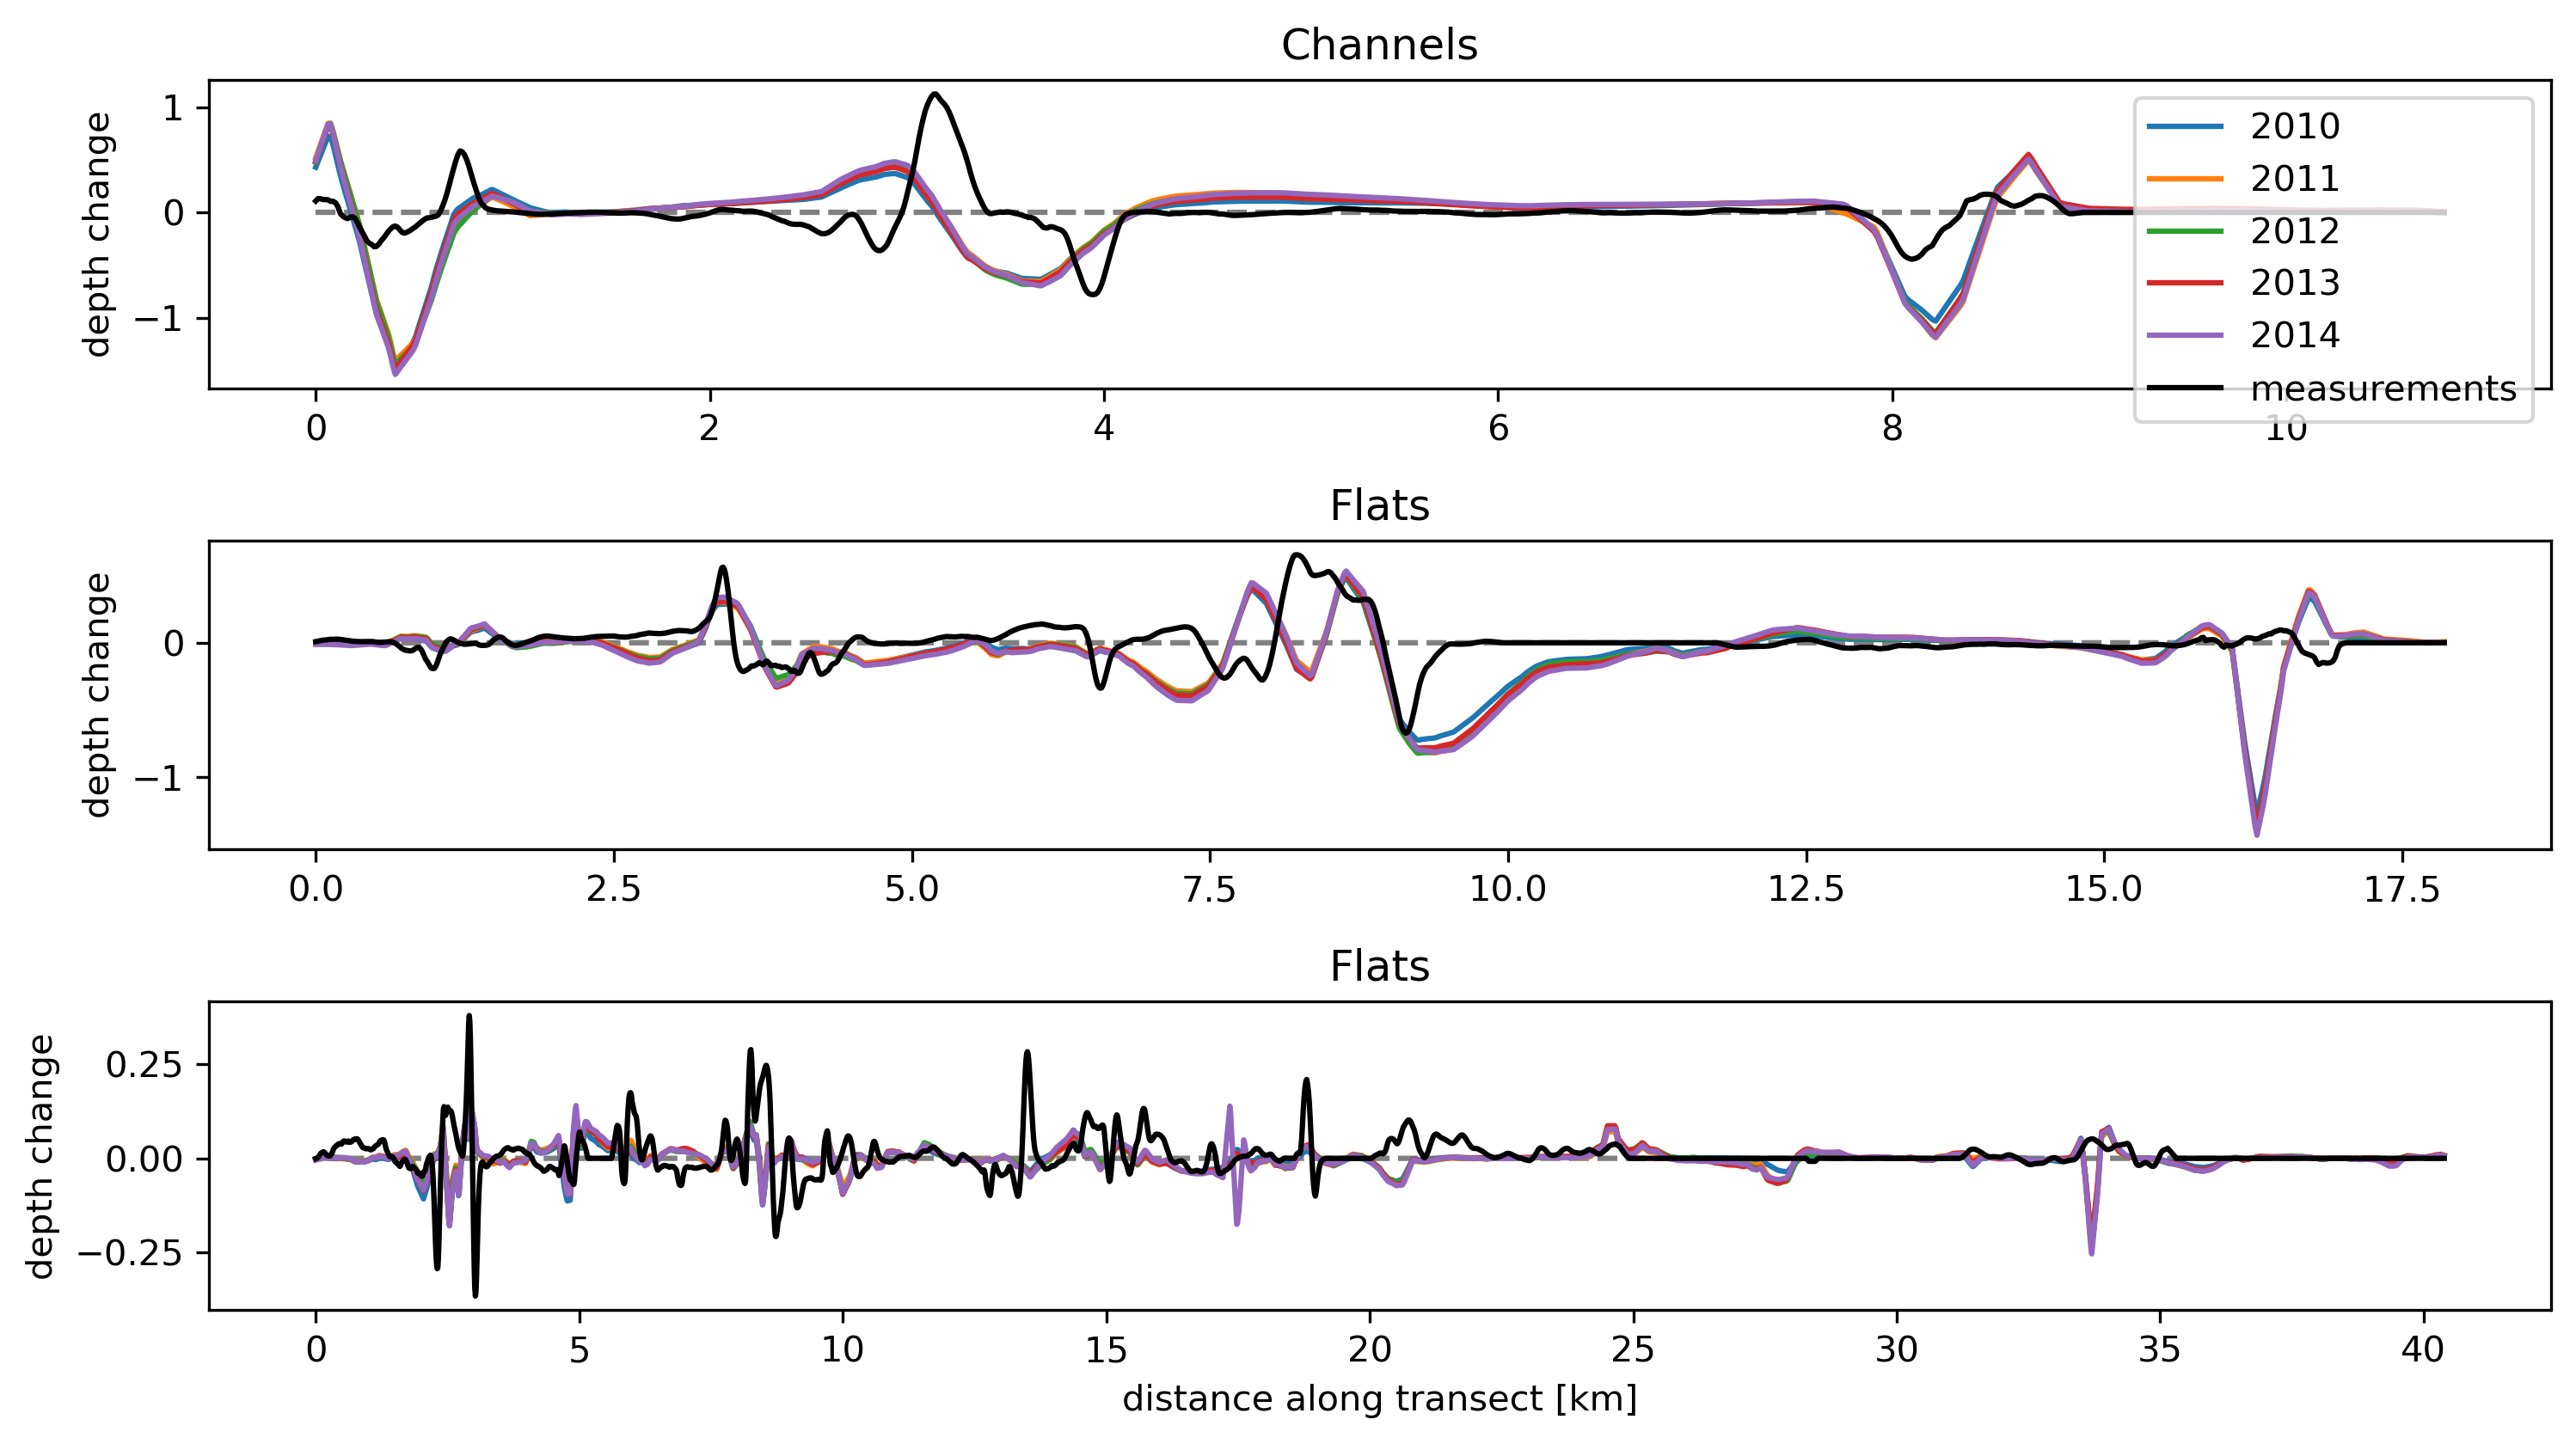

In [6]:
#depth changes sim:
#load sim data
from scipy.interpolate import griddata
from scipy.stats import pearsonr  
sumzcct_sim = np.zeros(np.size(cct_dist))
sumzcft_sim = np.zeros(np.size(cft_dist))
sumzcf2t_sim = np.zeros(np.size(cf2t_dist))

fig, axs = plt.subplots(3,1, figsize=(10, 6))
nsim = 0

axs[0].plot(cct_dist,[0]*np.size(cct_dist),'--',color='grey')
axs[1].plot(cft_dist,[0]*np.size(cft_dist),'--',color='grey')
axs[2].plot(cf2t_dist,[0]*np.size(cf2t_dist),'--',color='grey')

for i in range(2010,2015):

    ncf = simpat + basesims[0]+ str(i) + '/outputs/schout_365.nc'
    ncdata = Dataset(ncf, mode='r')
    depth_change   = -ncdata.variables['SED_depth_change'][-1,:]
    
    cct_diff = griddata((x,y),depth_change,(xcct,ycct),method='linear')
    cft_diff = griddata((x,y),depth_change,(xcft,ycft),method='linear')
    cf2t_diff = griddata((x,y),depth_change,(xcf2t,ycf2t),method='linear')
    
    sumzcct_sim += cct_diff
    sumzcft_sim += cft_diff
    sumzcf2t_sim += cf2t_diff

    nsim +=1
    
    cct_corr = pearsonr(cct_diff,sumzcct)
    cft_corr = pearsonr(cft_diff,sumzcft)
    cf2t_corr = pearsonr(cf2t_diff,sumzcf2t)
    print(str(i) + ' cct corr: ' + str(cct_corr[0]))
    print(str(i) + ' cft corr: ' + str(cft_corr[0]))
    print(str(i) + ' cf2t corr: ' + str(cf2t_corr[0]))

    axs[0].plot(cct_dist,cct_diff,label=str(i))
    axs[0].set_title('Channels')
    axs[0].set_ylabel('depth change')
  
    axs[1].plot(cft_dist,cft_diff,label=str(i))
    axs[1].set_title('Flats')
    axs[1].set_ylabel('depth change')
    
    axs[2].plot(cf2t_dist,cf2t_diff,label=str(i))
    axs[2].set_title('Flats')
    axs[2].set_xlabel('distance along transect [km]')
    axs[2].set_ylabel('depth change')
    plt.subplots_adjust(top=0.9)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

axs[0].plot(cct_dist,sumzcct,label='measurements',color='k')
axs[1].plot(cft_dist,sumzcft,color='k')
axs[2].plot(cf2t_dist,sumzcf2t,color='k')
axs[0].legend()

plt.savefig(plot_path + 'sim_depth_change_across_flats2_fine.png')
sumzcct_sim = sumzcct_sim/nsim
sumzcft_sim = sumzcft_sim/nsim
sumzcf2t_sim = sumzcf2t_sim/nsim 

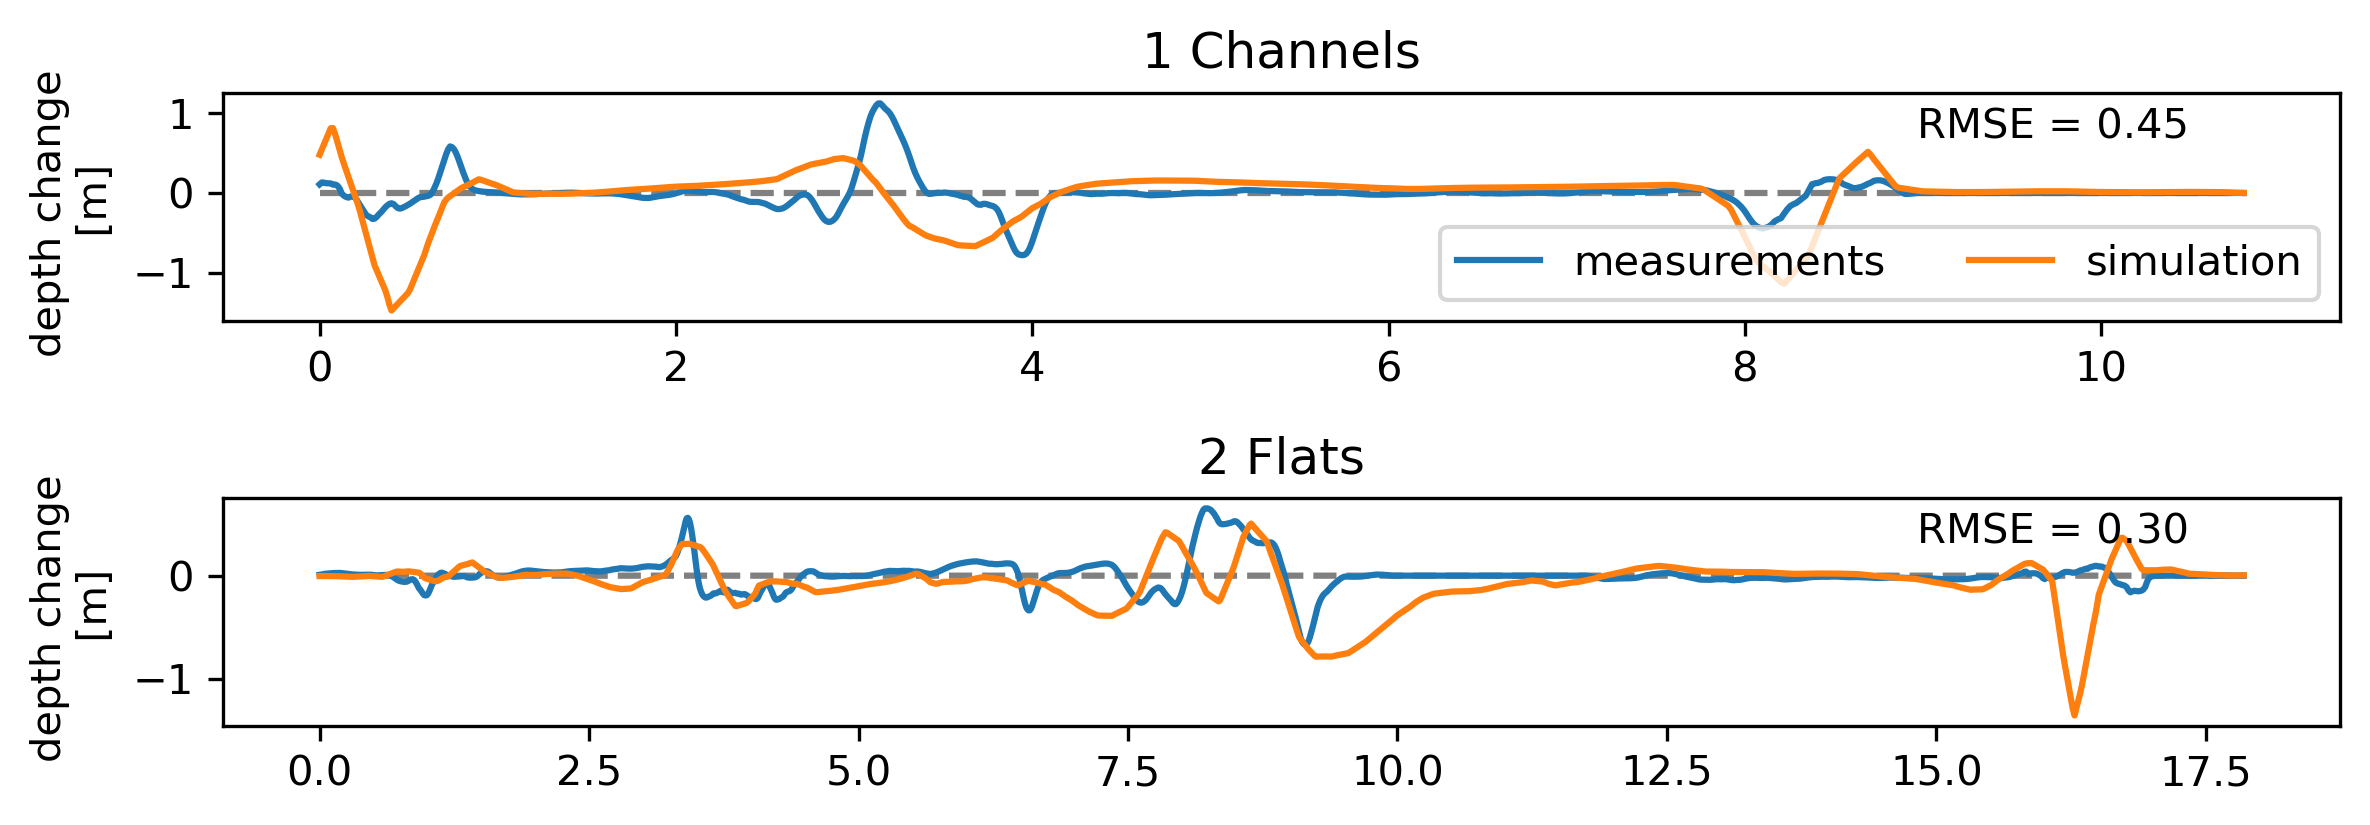

In [19]:
#depth changes sim mean change:
#load sim data
fig, axs = plt.subplots(2,1, figsize=(8,3)) 
nsim = 0

axs[0].plot(cct_dist,[0]*np.size(cct_dist),'--',color='grey')
axs[1].plot(cft_dist,[0]*np.size(cft_dist),'--',color='grey')
#axs[2].plot(cf2t_dist,[0]*np.size(cf2t_dist),'--',color='grey')

corcct = pearsonr(sumzcct,sumzcct_sim)
corcft = pearsonr(sumzcft,sumzcft_sim)
corcf2t = pearsonr(sumzcf2t,sumzcf2t_sim)
rmsecct = np.sqrt(np.mean((sumzcct+sumzcct_sim)**2))
rmsecft = np.sqrt(np.mean((sumzcft+sumzcft_sim)**2))
rmsecf2t = np.sqrt(np.mean((sumzcf2t+sumzcf2t_sim)**2))

#txt = 'RMSE = {rmse:.2f}, r = {r:.2f}'
txt = 'RMSE = {rmse:.2f}'
axs[0].plot(cct_dist,sumzcct,label='measurements')
axs[0].plot(cct_dist,sumzcct_sim,label='simulation')
#axs[0].text(0.65,0.8,txt.format(r = corcct[0],rmse=rmsecct), transform=axs[0].transAxes)
axs[0].text(0.8,0.8,txt.format(rmse=rmsecct), transform=axs[0].transAxes)
axs[0].set_title('1 Channels')
axs[0].set_ylabel('depth change \n [m]')

axs[1].plot(cft_dist,sumzcft)
axs[1].plot(cft_dist,sumzcft_sim)
#axs[1].text(0.65,0.8,txt.format(r = corcft[0],rmse=rmsecft), transform=axs[1].transAxes)
axs[1].text(0.8,0.8,txt.format(rmse=rmsecft), transform=axs[1].transAxes)

axs[1].set_title('2 Flats')
axs[1].set_ylabel('depth change \n [m]')

#axs[2].plot(cf2t_dist,sumzcf2t)
#axs[2].plot(cf2t_dist,sumzcf2t_sim)
#axs[2].text(0.65,0.8,txt.format(r = corcf2t[0],rmse=rmsecf2t), transform=axs[2].transAxes)
#axs[2].set_title('3 Flats (peripheral)')
#axs[2].set_xlabel('distance along transect [km]')
#axs[2].set_ylabel('depth change [m]')
plt.subplots_adjust(top=0.9)
plt.tight_layout(rect=[0, 0, 1, 0.95])


axs[0].legend(ncol=2,loc='lower right')

plt.savefig(plot_path + 'sim_depth_change_across_flats2_fine_mean.png')

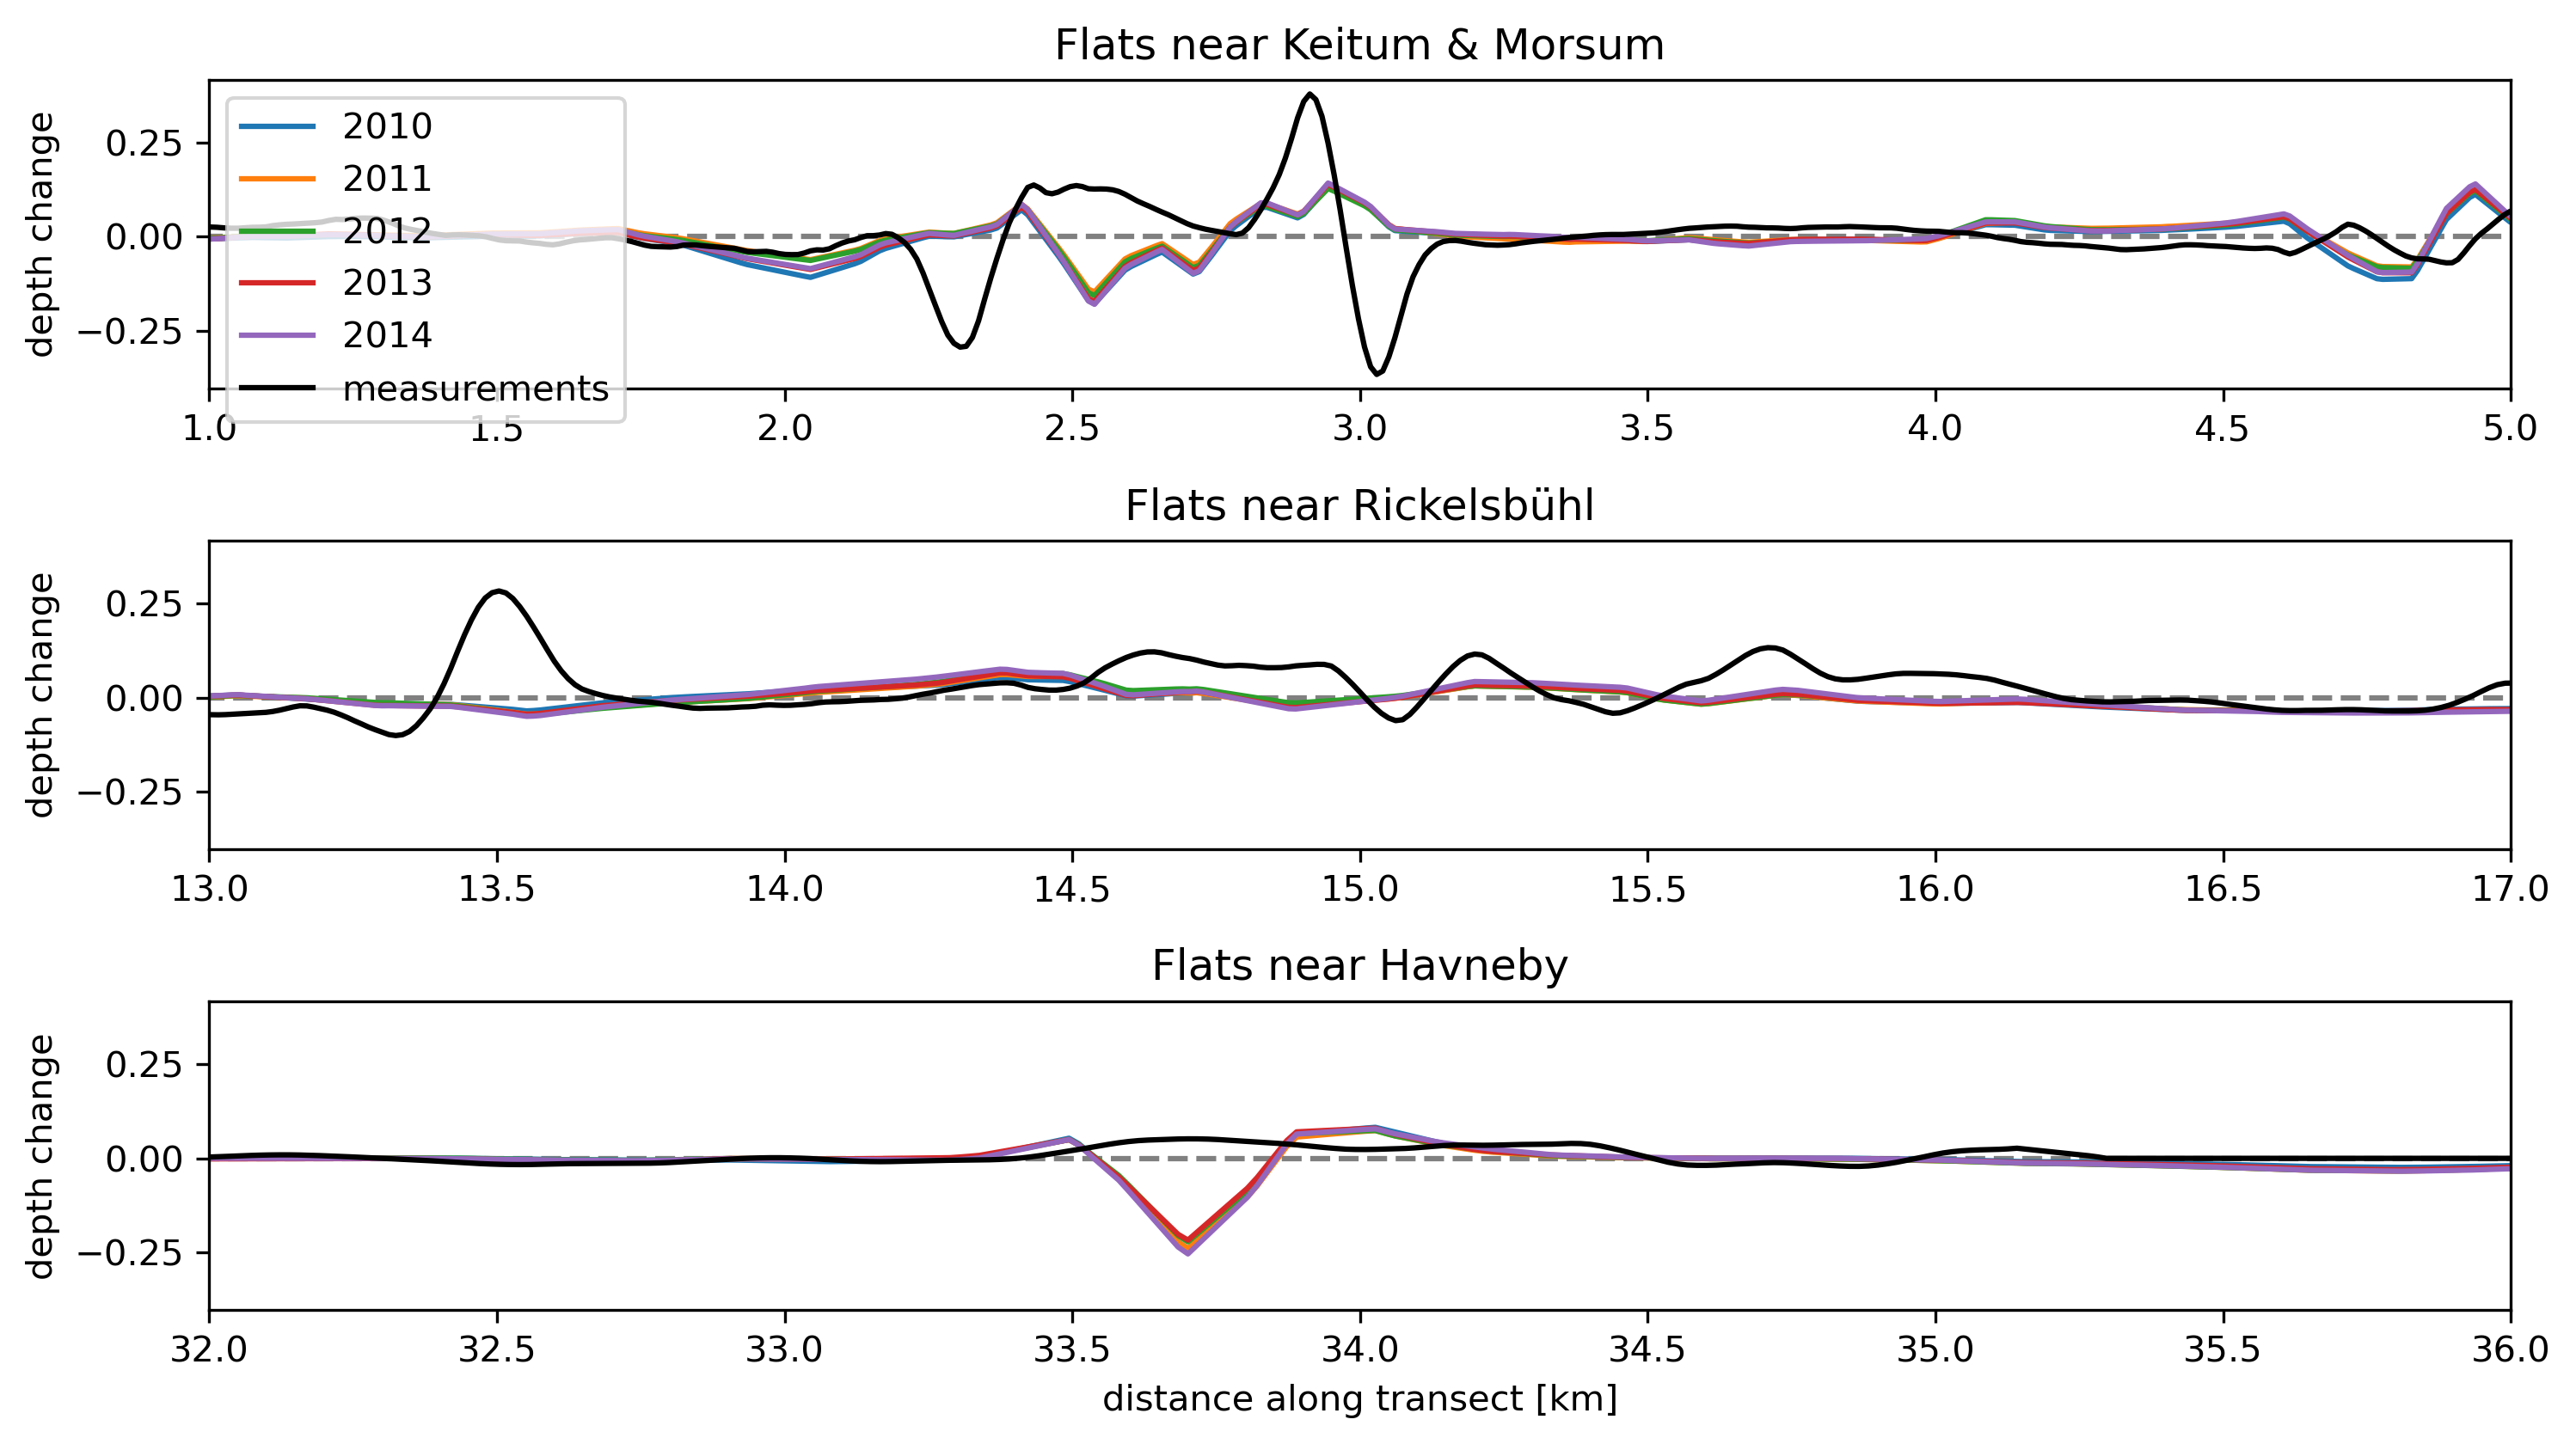

In [8]:
#depth changes sim at outskirts:
#load sim data
from scipy.interpolate import griddata
sumzcf2t_sim = np.zeros(np.size(cf2t_dist))

fig, axs = plt.subplots(3,1, figsize=(10, 6))
nsim = 0

axs[0].plot(cf2t_dist,[0]*np.size(cf2t_dist),'--',color='grey')
axs[1].plot(cf2t_dist,[0]*np.size(cf2t_dist),'--',color='grey')
axs[2].plot(cf2t_dist,[0]*np.size(cf2t_dist),'--',color='grey')

for i in range(2010,2015):
    ncf = simpat + basesims[0]+ str(i) + '/outputs/schout_365.nc'

    ncdata = Dataset(ncf, mode='r')
    depth_change   = -ncdata.variables['SED_depth_change'][-1,:]

    cf2t_diff = griddata((x,y),depth_change,(xcf2t,ycf2t),method='linear')

    sumzcf2t_sim += cf2t_diff

    nsim +=1

    axs[0].plot(cf2t_dist,cf2t_diff,label=str(i))
    axs[0].set_xlim([1,5])
    axs[0].set_title('Flats near Keitum & Morsum')
    axs[0].set_ylabel('depth change')
  
    axs[1].plot(cf2t_dist,cf2t_diff,label=str(i))
    axs[1].set_xlim([13,17])
    axs[1].set_title('Flats near Rickelsbühl')
    axs[1].set_ylabel('depth change')
    
    axs[2].plot(cf2t_dist,cf2t_diff,label=str(i))
    axs[2].set_xlim([32,36])
    axs[2].set_title('Flats near Havneby')
    axs[2].set_xlabel('distance along transect [km]')
    axs[2].set_ylabel('depth change')
    plt.subplots_adjust(top=0.9)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

axs[0].plot(cf2t_dist,sumzcf2t,label='measurements',color='k')
axs[1].plot(cf2t_dist,sumzcf2t,color='k')
axs[2].plot(cf2t_dist,sumzcf2t,color='k')
axs[0].legend()

plt.savefig(plot_path + 'sim_depth_change_across_flats2_fine_sections.png')
sumzcf2t_sim = sumzcf2t_sim/nsim

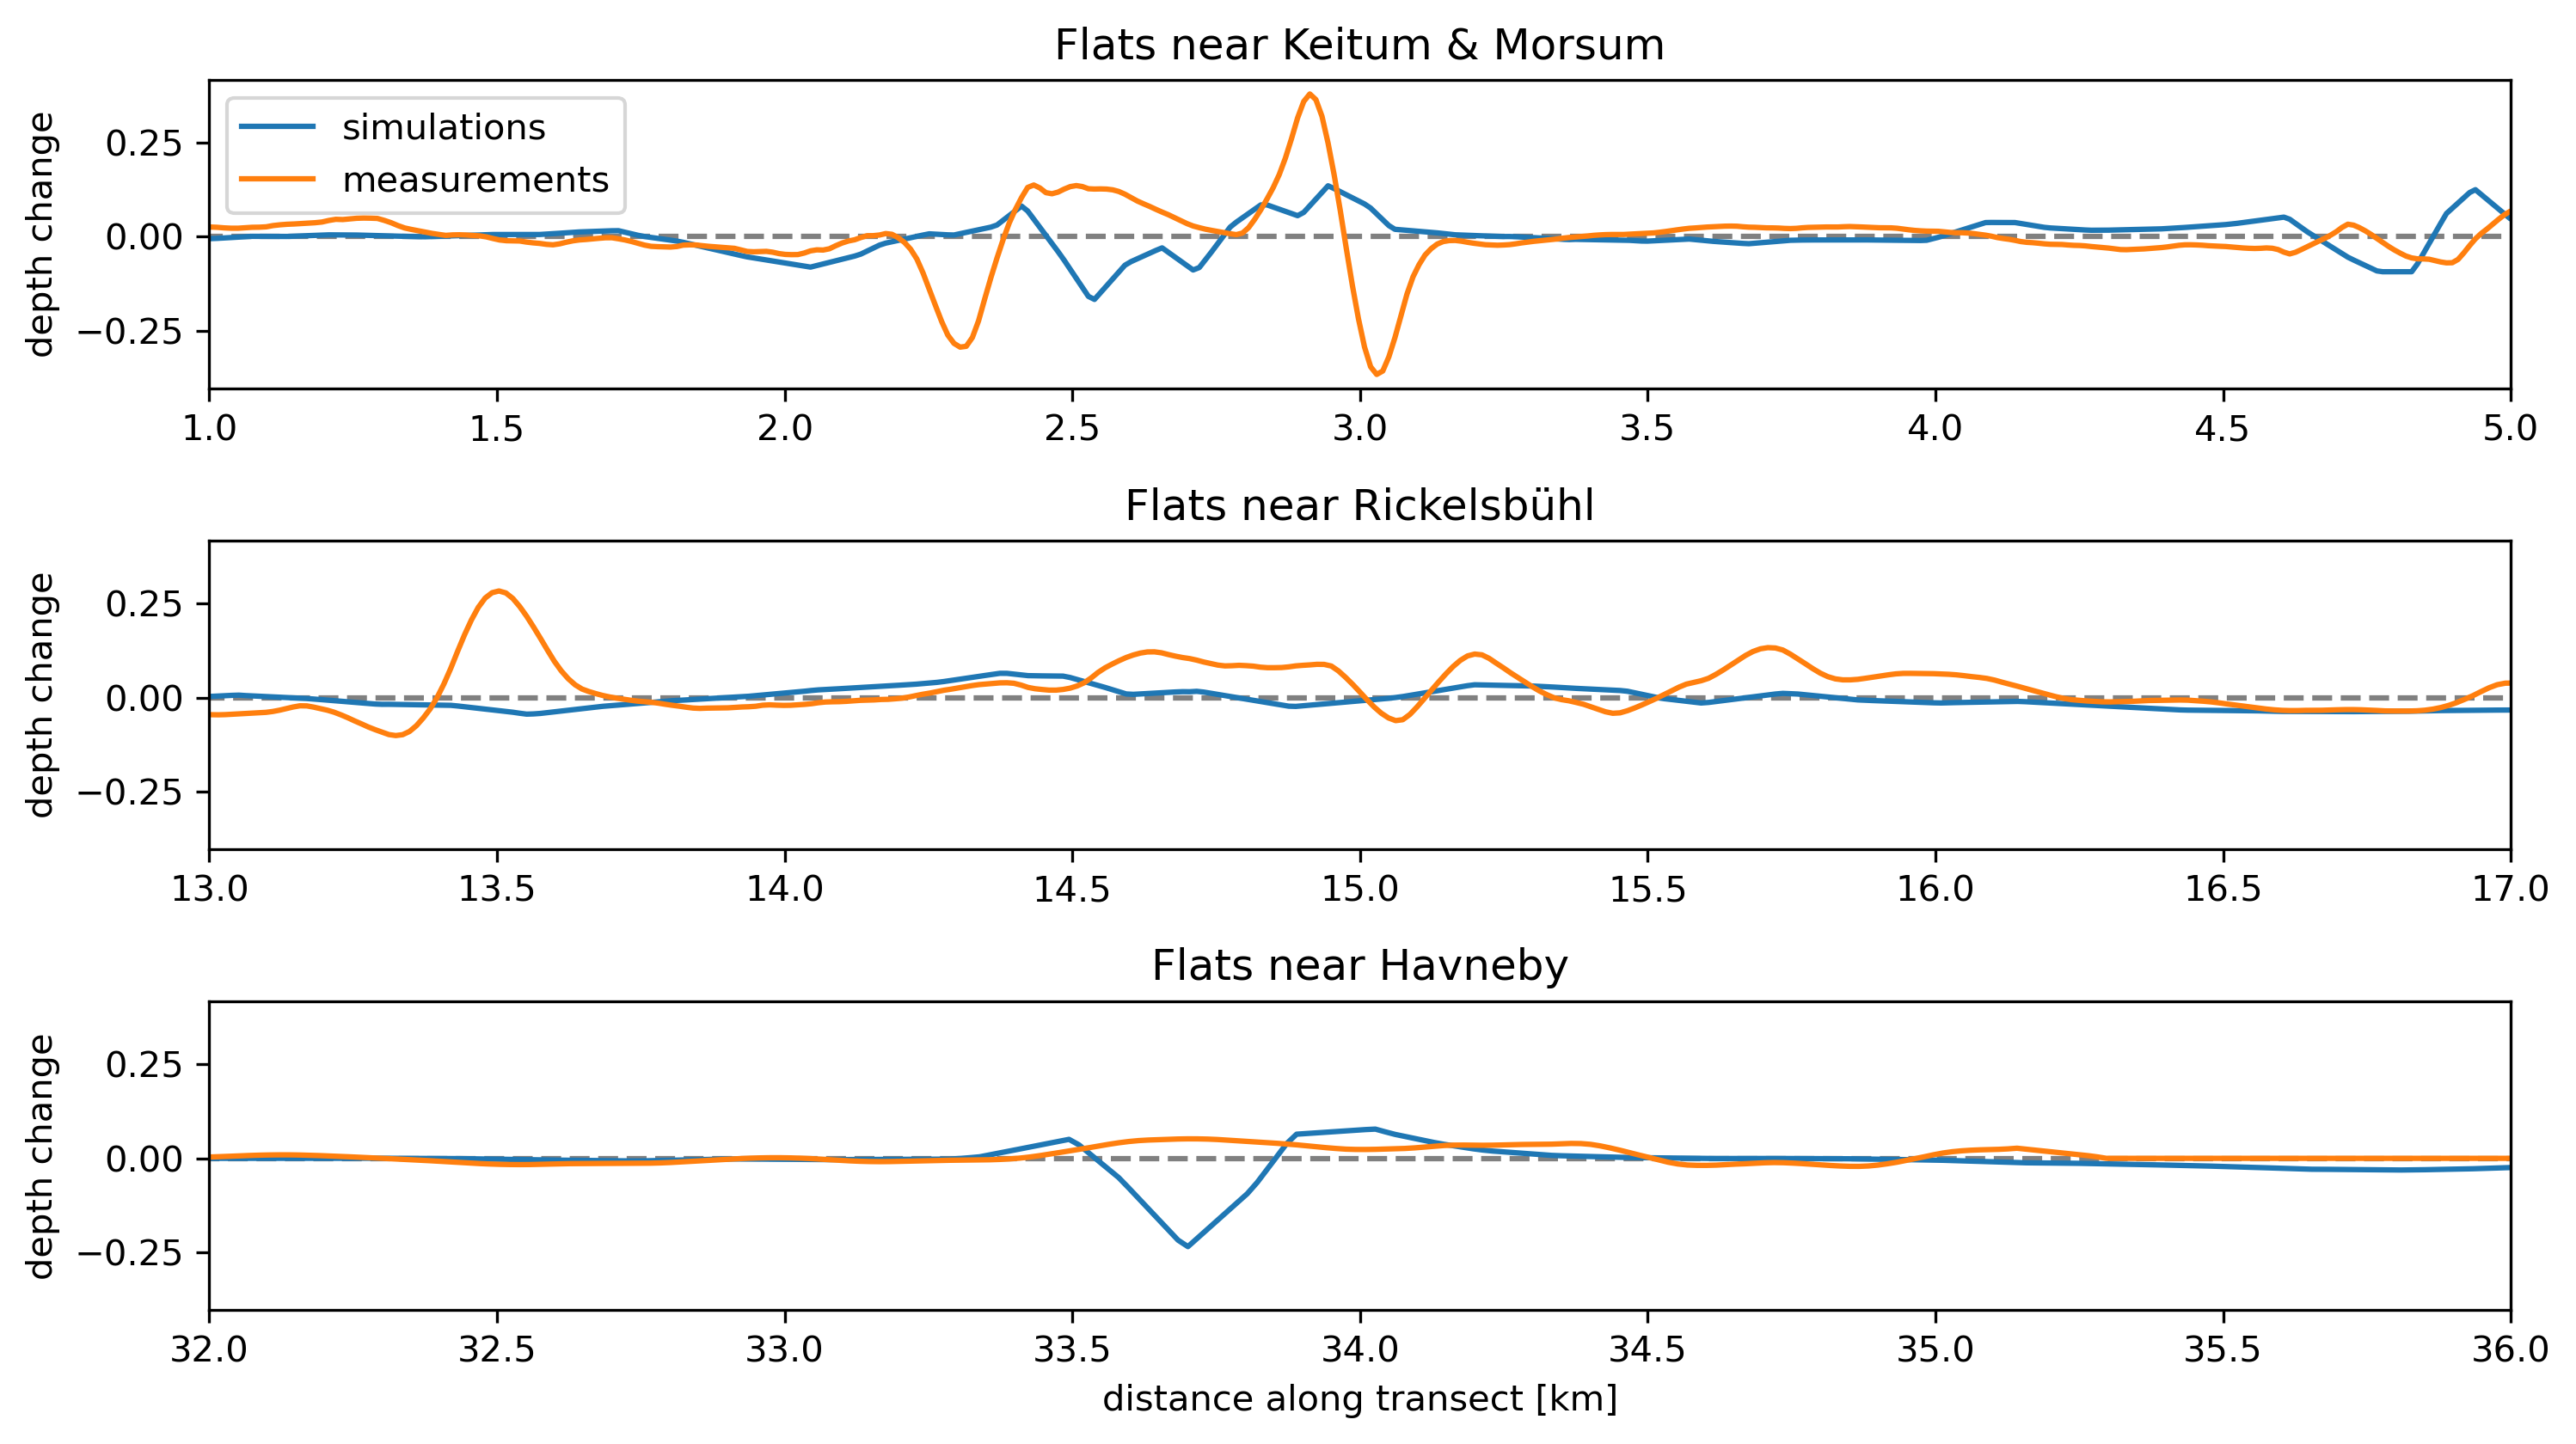

In [9]:
#depth changes sim at outskirts mean:
#load sim data
fig, axs = plt.subplots(3,1, figsize=(10, 6))

axs[0].plot(cf2t_dist,[0]*np.size(cf2t_dist),'--',color='grey')
axs[1].plot(cf2t_dist,[0]*np.size(cf2t_dist),'--',color='grey')
axs[2].plot(cf2t_dist,[0]*np.size(cf2t_dist),'--',color='grey')

axs[0].plot(cf2t_dist,sumzcf2t_sim,label='simulations')
axs[0].set_xlim([1,5])
axs[0].set_title('Flats near Keitum & Morsum')
axs[0].set_ylabel('depth change')

axs[1].plot(cf2t_dist,sumzcf2t_sim)
axs[1].set_xlim([13,17])
axs[1].set_title('Flats near Rickelsbühl')
axs[1].set_ylabel('depth change')

axs[2].plot(cf2t_dist,sumzcf2t_sim)
axs[2].set_xlim([32,36])
axs[2].set_title('Flats near Havneby')
axs[2].set_xlabel('distance along transect [km]')
axs[2].set_ylabel('depth change')
plt.subplots_adjust(top=0.9)
plt.tight_layout(rect=[0, 0, 1, 0.95])

axs[0].plot(cf2t_dist,sumzcf2t,label='measurements')
axs[1].plot(cf2t_dist,sumzcf2t)
axs[2].plot(cf2t_dist,sumzcf2t)
axs[0].legend()

plt.savefig(plot_path + 'sim_depth_change_across_flats2_fine_sections_mean.png')

2010 corr: -0.018329910040599515
2011 corr: -0.0534168205727666
2012 corr: -0.04848482316776079
2013 corr: -0.038392996836098536
2014 corr: -0.02374681631256291


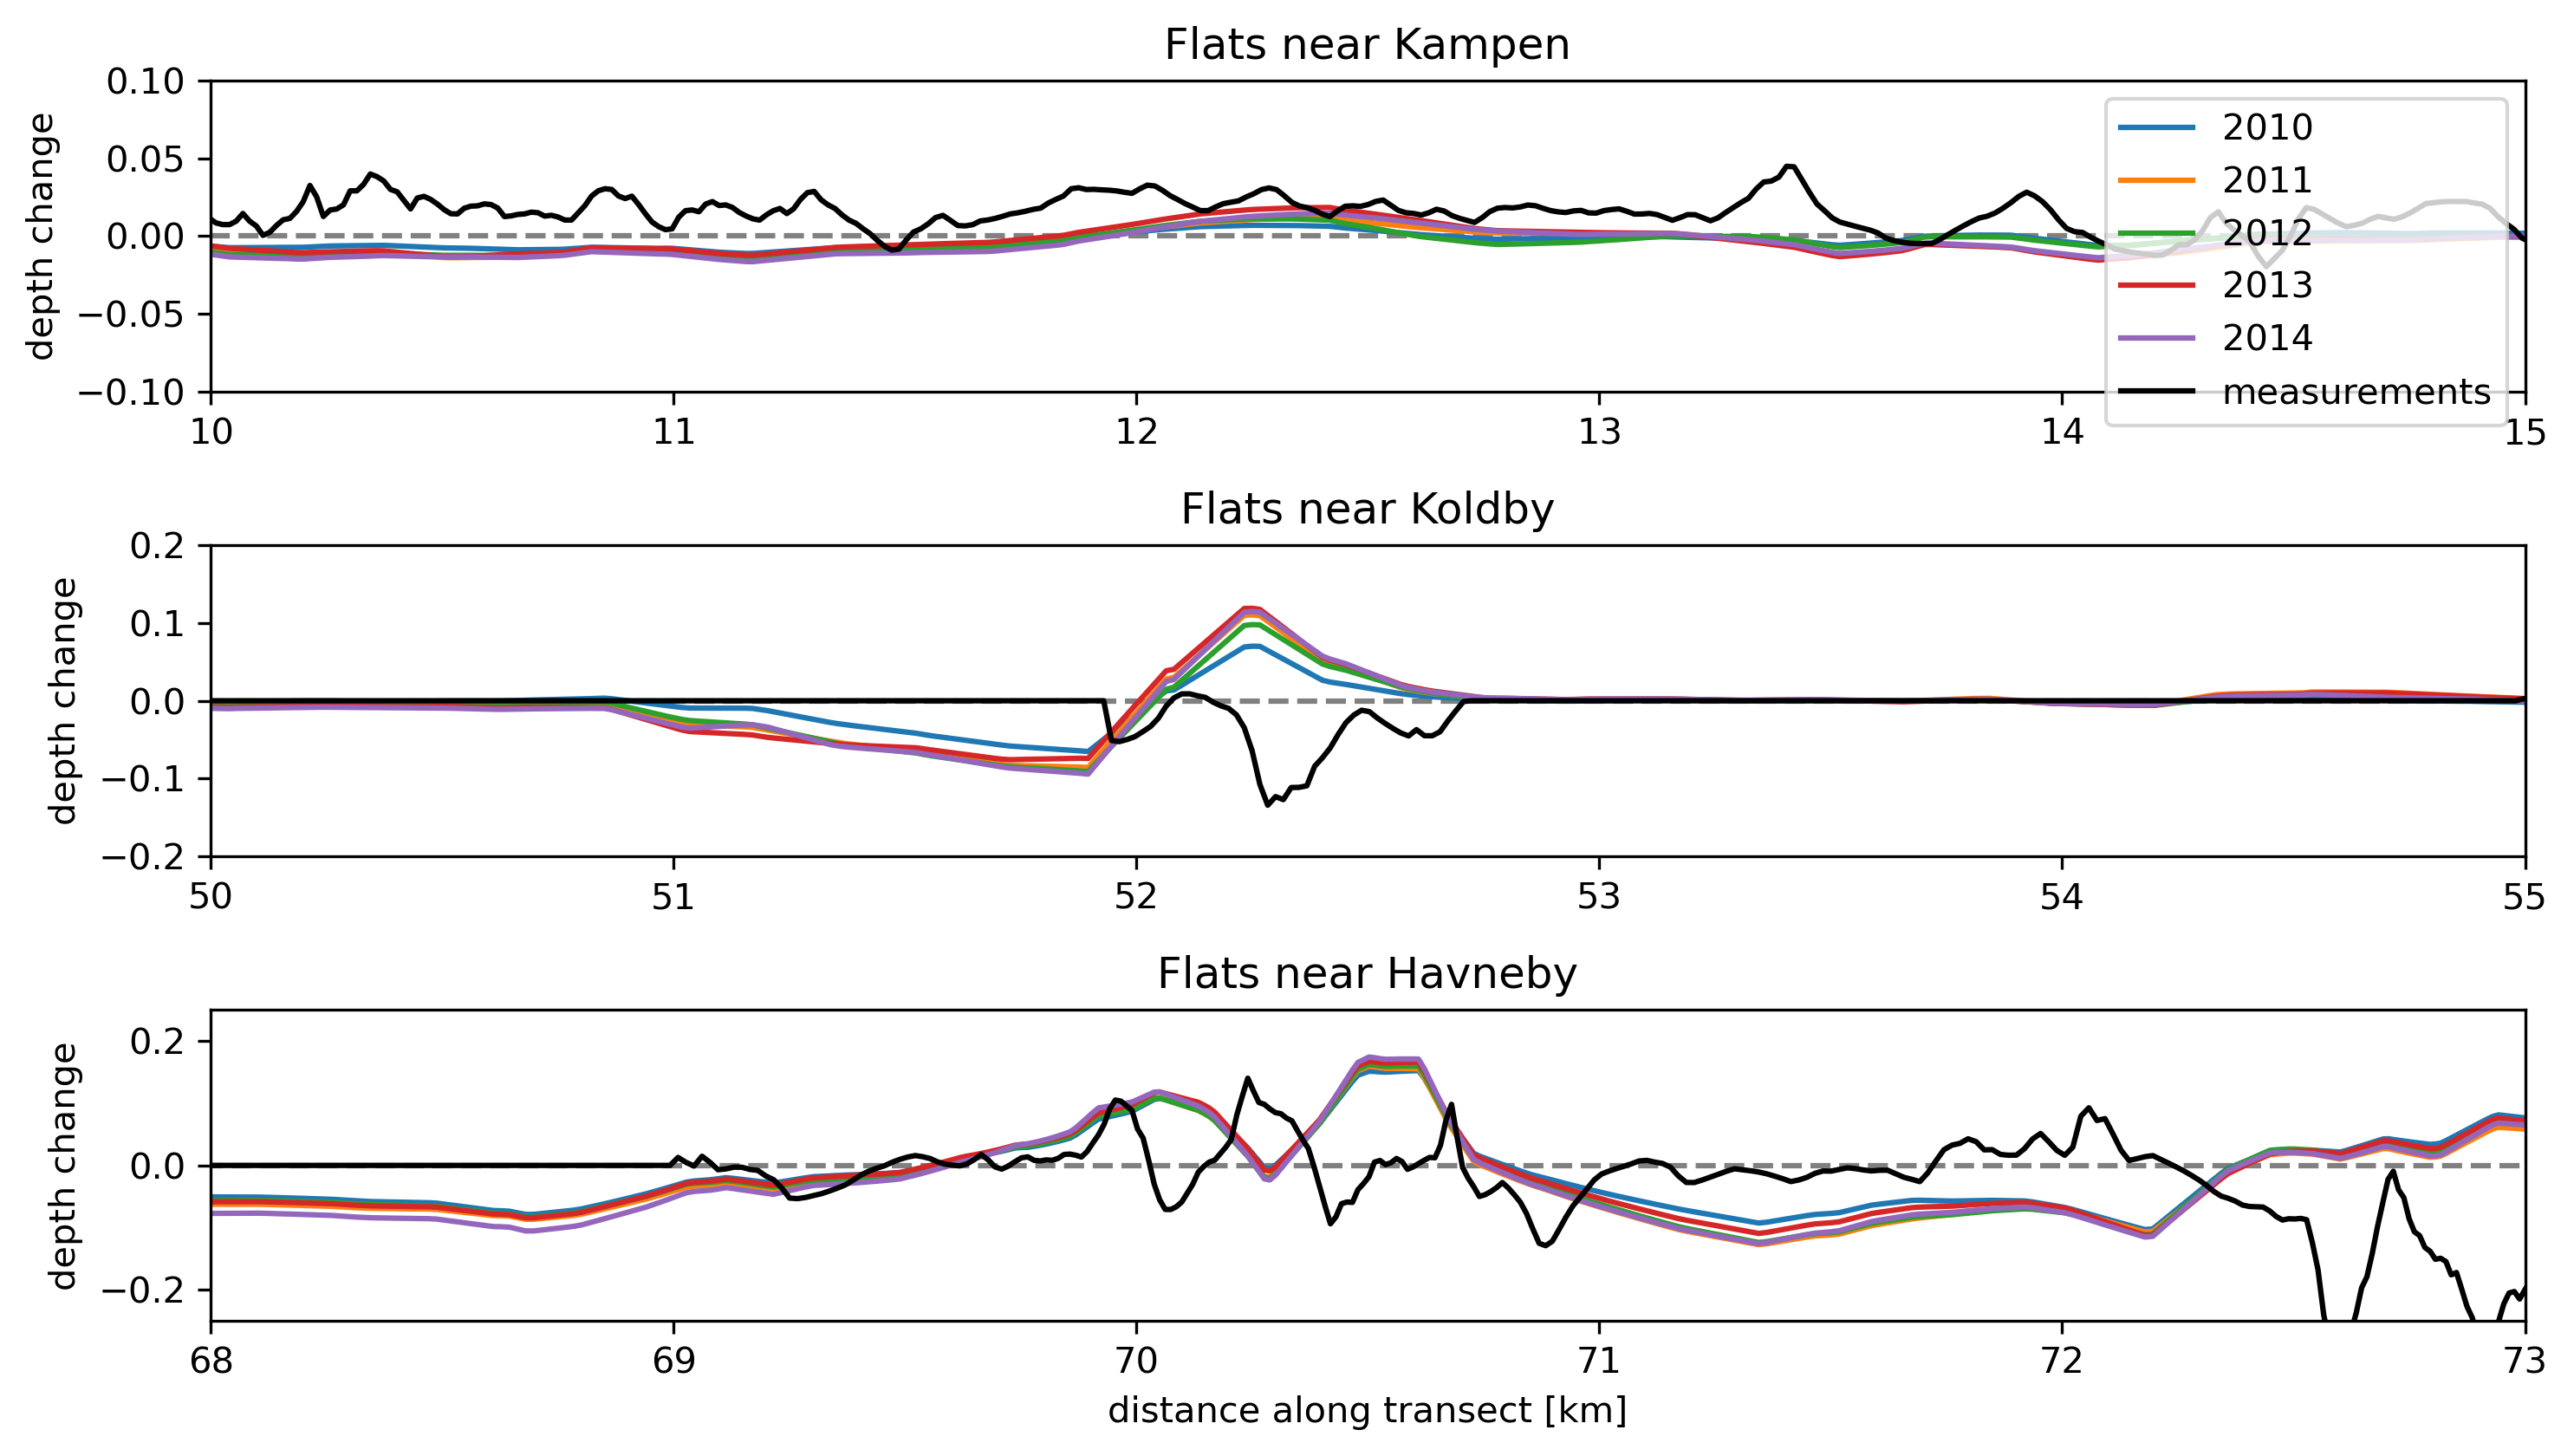

In [10]:
#depth changes sim at boundary:
#load sim data
from scipy.interpolate import griddata
from scipy.stats import pearsonr  

sumzbnd_sim = np.zeros(np.size(bnd_dist))

fig, axs = plt.subplots(3,1, figsize=(10, 6))
nsim = 0

axs[0].plot(bnd_dist,[0]*np.size(bnd_dist),'--',color='grey')
axs[1].plot(bnd_dist,[0]*np.size(bnd_dist),'--',color='grey')
axs[2].plot(bnd_dist,[0]*np.size(bnd_dist),'--',color='grey')

for i in range(2010,2015):

    ncf = simpat + basesims[0]+ str(i) + '/outputs/schout_365.nc'

    ncdata = Dataset(ncf, mode='r')
    depth_change   = -ncdata.variables['SED_depth_change'][-1,:]

    bnd_diff = griddata((x,y),depth_change,(xbnd,ybnd),method='linear')
    
    corr = pearsonr(bnd_diff,-sumzbnd)
    print(str(i) + ' corr: ' + str(corr[0]))

    sumzbnd_sim += bnd_diff

    nsim +=1

    axs[0].plot(bnd_dist,bnd_diff,label=str(i))
    axs[0].set_xlim([10,15])
    axs[0].set_ylim([-0.1,0.1])
    axs[0].set_title('Flats near Kampen')
    axs[0].set_ylabel('depth change')
  
    axs[1].plot(bnd_dist,bnd_diff,label=str(i))
    axs[1].set_xlim([50,55])
    axs[1].set_ylim([-0.2,0.2])
    axs[1].set_title('Flats near Koldby')
    axs[1].set_ylabel('depth change')
    
    axs[2].plot(bnd_dist,bnd_diff,label=str(i))
    axs[2].set_xlim([68,73])
    axs[2].set_ylim([-0.25,0.25])
    axs[2].set_title('Flats near Havneby')
    axs[2].set_xlabel('distance along transect [km]')
    axs[2].set_ylabel('depth change')
    plt.subplots_adjust(top=0.9)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

axs[0].plot(bnd_dist,sumzbnd,label='measurements',color='k')
axs[1].plot(bnd_dist,sumzbnd,color='k')
axs[2].plot(bnd_dist,sumzbnd,color='k')
axs[0].legend()

plt.savefig(plot_path + 'sim_depth_change_boundary_fine_sections.png')
sumzbnd_sim = sumzbnd_sim/nsim

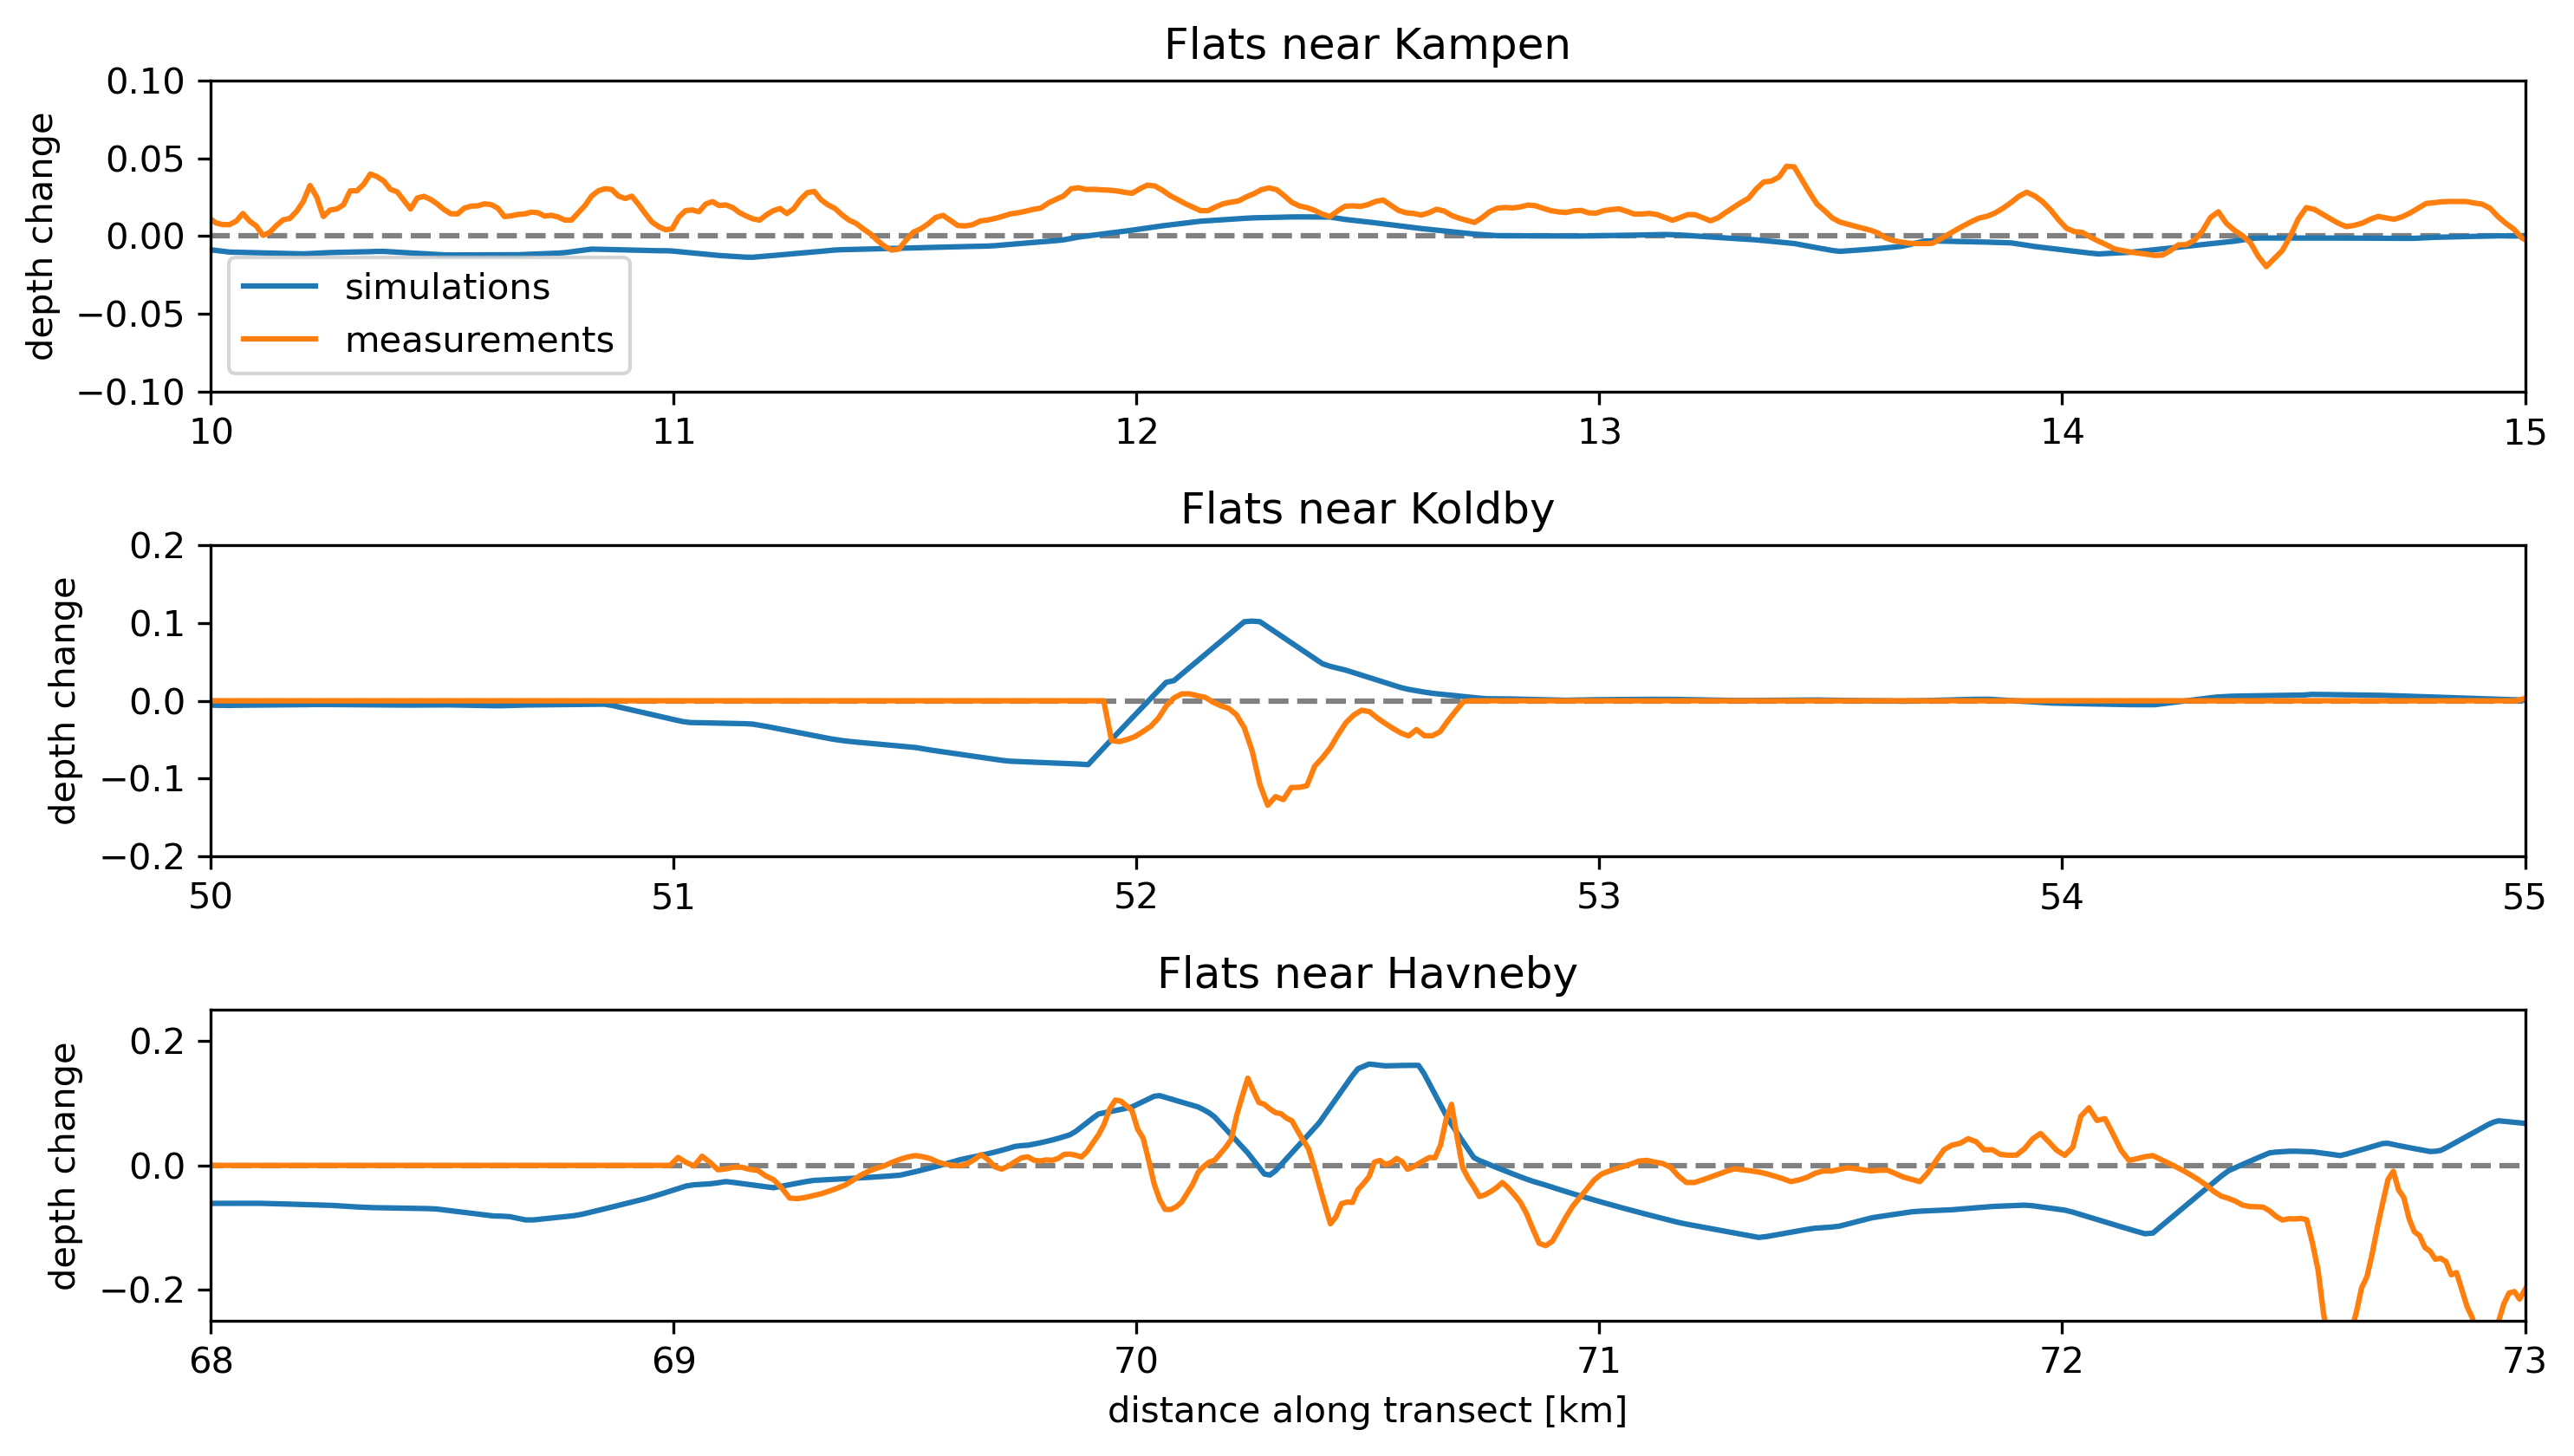

In [11]:
#depth changes sim at boundary:
#load sim data
fig, axs = plt.subplots(3,1, figsize=(10, 6))
nsim = 0

axs[0].plot(bnd_dist,[0]*np.size(bnd_dist),'--',color='grey')
axs[1].plot(bnd_dist,[0]*np.size(bnd_dist),'--',color='grey')
axs[2].plot(bnd_dist,[0]*np.size(bnd_dist),'--',color='grey')

axs[0].plot(bnd_dist,sumzbnd_sim,label='simulations')
axs[0].set_xlim([10,15])
axs[0].set_ylim([-0.1,0.1])
axs[0].set_title('Flats near Kampen')
axs[0].set_ylabel('depth change')

axs[1].plot(bnd_dist,sumzbnd_sim)
axs[1].set_xlim([50,55])
axs[1].set_ylim([-0.2,0.2])
axs[1].set_title('Flats near Koldby')
axs[1].set_ylabel('depth change')

axs[2].plot(bnd_dist,sumzbnd_sim)
axs[2].set_xlim([68,73])
axs[2].set_ylim([-0.25,0.25])
axs[2].set_title('Flats near Havneby')
axs[2].set_xlabel('distance along transect [km]')
axs[2].set_ylabel('depth change')


axs[0].plot(bnd_dist,sumzbnd,label='measurements')
axs[1].plot(bnd_dist,sumzbnd)
axs[2].plot(bnd_dist,sumzbnd)
axs[0].legend()

plt.subplots_adjust(top=0.9)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(plot_path + 'sim_depth_change_boundary_fine_sections_mean.png')

In [12]:
bnd_dist

array([0.00000000e+00, 1.14219953e-02, 2.28440019e-02, ...,
       7.91458242e+01, 7.91592661e+01, 7.91727080e+01])